> **IMPORTANT**: Before running this notebook, ensure you have ran:
> ```bash
> python ./scripts/preprocessing/preprocess_data.py
> ``` 
> You will know if you ran this if you see a `pickled_objects` folder in your root directory. This folder will be used to load in preprocessed data and the saved preprcoessor.

# Import Libraries

In [1]:
from utils.preprocessing import load_preprocessed_data, load_preprocessor
from models.mlp import MLP, Trainer, ASLDataset, plot_history
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/Users/danielplotkin/Documents/MSAI/courses/fall_2024/machine_learning/homework/msai349/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get Data and Preprocesssor

In [2]:
train_data = load_preprocessed_data('train')
val_data = load_preprocessed_data('val')
test_data = load_preprocessed_data('test')
preprocessor = load_preprocessor()

# Train Models

## MLP

### Initialize Network

In [3]:
input_dim = train_data[0].shape[-1]
output_dim = len(np.unique(train_data[-1]))
model = MLP(input_dim=input_dim, output_dim=output_dim)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=29, bias=True)
  )
)


### Initialize Trainer

In [4]:
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    learning_rate=5e-4,
    loss_fn=nn.CrossEntropyLoss(),
    dataset_cls=ASLDataset,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    batch_size=32,
    num_epochs=100,
    patience=3
)

### Train Model

In [5]:
history = trainer.train()

Epoch 1/100:


Val Loss: 1.3418, Val Acc: 0.5266: 100%|██████████| 435/435 [00:02<00:00, 197.28it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 2/100:


Val Loss: 0.8194, Val Acc: 0.7190: 100%|██████████| 435/435 [00:02<00:00, 200.93it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 3/100:


Val Loss: 0.5921, Val Acc: 0.7858: 100%|██████████| 435/435 [00:02<00:00, 195.06it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 4/100:


Val Loss: 0.5819, Val Acc: 0.7769: 100%|██████████| 435/435 [00:02<00:00, 211.38it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 5/100:


Val Loss: 0.5023, Val Acc: 0.8112: 100%|██████████| 435/435 [00:02<00:00, 209.88it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 6/100:


Val Loss: 0.3805, Val Acc: 0.8657: 100%|██████████| 435/435 [00:02<00:00, 207.82it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 7/100:


Val Loss: 0.4940, Val Acc: 0.8172: 100%|██████████| 435/435 [00:02<00:00, 211.29it/s]



Epoch 8/100:


Val Loss: 0.4454, Val Acc: 0.8384: 100%|██████████| 435/435 [00:02<00:00, 206.92it/s]



Epoch 9/100:


Val Loss: 0.2045, Val Acc: 0.9287: 100%|██████████| 435/435 [00:02<00:00, 208.20it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 10/100:


Val Loss: 0.2174, Val Acc: 0.9205: 100%|██████████| 435/435 [00:02<00:00, 205.28it/s]



Epoch 11/100:


Val Loss: 0.2914, Val Acc: 0.8874: 100%|██████████| 435/435 [00:02<00:00, 212.29it/s]



Epoch 12/100:


Val Loss: 0.1920, Val Acc: 0.9275: 100%|██████████| 435/435 [00:02<00:00, 195.38it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 13/100:


Val Loss: 0.3779, Val Acc: 0.8622: 100%|██████████| 435/435 [00:02<00:00, 208.80it/s]



Epoch 14/100:


Val Loss: 0.2747, Val Acc: 0.9009: 100%|██████████| 435/435 [00:02<00:00, 205.33it/s]



Epoch 15/100:


Val Loss: 0.2998, Val Acc: 0.8971: 100%|██████████| 435/435 [00:02<00:00, 200.71it/s]


Early stopping triggered at epoch 15.
Restoring weights back to epoch 12.


### Visualize Training

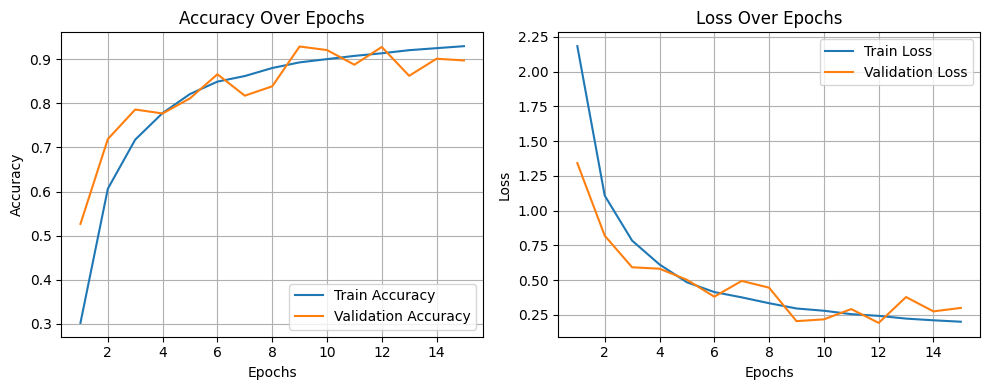

In [6]:
plot_history(history=history)

### Evalaute Model on Test Set

In [7]:
_ = trainer.evaluate(loader_type='test')

Test Loss: 0.1908, Test Acc: 0.9273: 100%|██████████| 544/544 [00:02<00:00, 205.80it/s]


### Make Predictions

In [8]:
def make_mlp_predictions(n_samples: int) -> None:
    random_idxs = np.random.randint(0, len(test_data[0]), n_samples)
    trues = []
    preds = []
    for idx in random_idxs:
        X_test = test_data[0][idx].reshape(1, -1)
        y_true = [test_data[-1][idx]]
        pred = trainer.predict(X_test)
        preds.append(pred)
        trues.append(y_true)
        pred_label = preprocessor.label_encoder.inverse_transform(pred)
        true_label = preprocessor.label_encoder.inverse_transform(y_true)
        print(f'True: {true_label}, Pred: {pred_label}')
    print('*'*50)
    print(f'Accuracy for {n_samples} random test samples: {np.mean((np.array(trues).flatten() == np.array(preds).flatten()))}')


make_mlp_predictions(20)

True: ['C'], Pred: ['C']
True: ['O'], Pred: ['O']
True: ['U'], Pred: ['U']
True: ['I'], Pred: ['I']
True: ['R'], Pred: ['R']
True: ['E'], Pred: ['E']
True: ['E'], Pred: ['E']
True: ['K'], Pred: ['K']
True: ['P'], Pred: ['P']
True: ['M'], Pred: ['M']
True: ['V'], Pred: ['V']
True: ['U'], Pred: ['R']
True: ['N'], Pred: ['N']
True: ['L'], Pred: ['L']
True: ['Q'], Pred: ['Q']
True: ['W'], Pred: ['W']
True: ['K'], Pred: ['K']
True: ['T'], Pred: ['T']
True: ['K'], Pred: ['K']
True: ['space'], Pred: ['space']
**************************************************
Accuracy for 20 random test samples: 0.95
